### imports

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow

# EDA

##### Loading train and inference files

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive
39996,"The first (and only) time I saw ""Shades"" was d...",negative
39997,This was such a waste of time. Danger: If you ...,negative
39998,this is by far the most pathetic movie Indian ...,negative


In [3]:
df_inf = pd.read_csv("../data/raw/inference.csv")
df_inf

,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative
...,...,...
9995,SILVER CITY (2+ outta 5 stars) As a huge fan o...,negative
9996,Moscow Zero stole my money and I want it back!...,negative
9997,This is the only film I've seen that is made b...,negative
9998,"This is a story about Shin-ae, who moves to Mi...",positive


##### Checking data imbalance in target column (everything is perfect in each datasets target is 50/50 distibuted, which is amazing for training and evaluation)

In [4]:
df.sentiment.value_counts()

sentiment
positive    20000
negative    20000
Name: count, dtype: int64

In [5]:
df_inf.sentiment.value_counts()

sentiment
negative    5000
positive    5000
Name: count, dtype: int64

##### Also data is free from missing values

In [6]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df_inf.isna().sum()

review       0
sentiment    0
dtype: int64

##### But surprisingly there are some duplicates in each dataset

In [8]:
df.duplicated().sum()

np.int64(272)

In [9]:
df_inf.duplicated().sum()

np.int64(13)

##### Delete duplicates and convert target to number (1,0) - int

In [10]:
df.drop_duplicates()
df_inf.drop_duplicates()

,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative
...,...,...
9995,SILVER CITY (2+ outta 5 stars) As a huge fan o...,negative
9996,Moscow Zero stole my money and I want it back!...,negative
9997,This is the only film I've seen that is made b...,negative
9998,"This is a story about Shin-ae, who moves to Mi...",positive


In [11]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df_inf['sentiment'] = df_inf['sentiment'].map({'positive': 1, 'negative': 0})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


##### Length of review distribution (most reviews below 2000 characters, but some as long as 14000)

<Axes: >

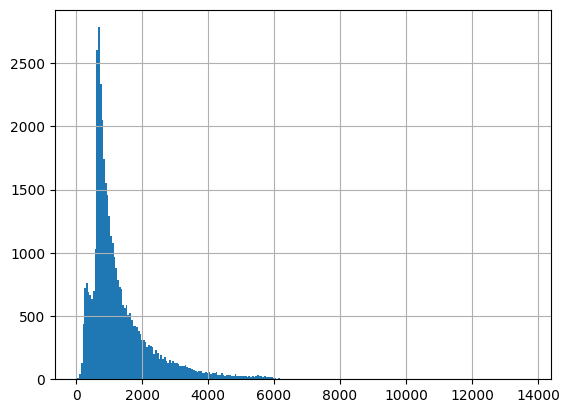

In [12]:
df['review'].str.len().hist(bins="auto")

# Feature engineering

##### All text to lowercase and removing all (punct, numb) except a-z and spaces

In [13]:
df['review_az'] = df["review"].str.lower().str.replace(r'[^a-z\s]', ' ', regex=True).str.replace(' +', ' ', regex=True)
df_inf['review_az'] = df_inf["review"].str.lower().str.replace(r'[^a-z\s]', ' ', regex=True).str.replace(' +', ' ', regex=True)

#i do it this way because sometimes space after punctuation is missing, so in order to eliminate situation when 'should,but' becomes 'shouldbut'
#i replace all that is not letter with space character and then replacing multiple spaces to one space

#also stopwords list has forms as "can't", but doesn't have form "cant", but giving my approach i achieve "can t", 
# so stopwords will filter word "can" and i can remove all one letter words resulting in smaller and cleaner data

In [14]:
df.head()

,review,sentiment,review_az
0,I caught this little gem totally by accident b...,1,i caught this little gem totally by accident b...
1,I can't believe that I let myself into this mo...,0,i can t believe that i let myself into this mo...
2,*spoiler alert!* it just gets to me the nerve ...,0,spoiler alert it just gets to me the nerve so...
3,If there's one thing I've learnt from watching...,0,if there s one thing i ve learnt from watching...
4,"I remember when this was in theaters, reviews ...",0,i remember when this was in theaters reviews s...


##### Tokenize and remove stopwords

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
def process_text(text):
    #tokenize 
    tokens = word_tokenize(text)
    
    #filter
    clean_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]    
    return clean_tokens

In [17]:
df['review_tokens'] = df['review_az'].apply(process_text)
df_inf['review_tokens'] = df_inf['review_az'].apply(process_text)

df.head()

,review,sentiment,review_az,review_tokens
0,I caught this little gem totally by accident b...,1,i caught this little gem totally by accident b...,"[caught, little, gem, totally, accident, back,..."
1,I can't believe that I let myself into this mo...,0,i can t believe that i let myself into this mo...,"[believe, let, movie, accomplish, favor, frien..."
2,*spoiler alert!* it just gets to me the nerve ...,0,spoiler alert it just gets to me the nerve so...,"[spoiler, alert, gets, nerve, people, remake, ..."
3,If there's one thing I've learnt from watching...,0,if there s one thing i ve learnt from watching...,"[one, thing, learnt, watching, george, romero,..."
4,"I remember when this was in theaters, reviews ...",0,i remember when this was in theaters reviews s...,"[remember, theaters, reviews, said, horrible, ..."


##### Stemmer vs Lemmatizer comparison on first review

In [18]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

tokens = df['review_tokens'].iloc[0]

comparison_data = []

for token in tokens:
    stem = stemmer.stem(token)
    
    lemma_noun = lemmatizer.lemmatize(token, pos='n')
    lemma_verb = lemmatizer.lemmatize(token, pos='v') 
    lemma_adj  = lemmatizer.lemmatize(token, pos='a')

    comparison_data.append({
        "Original": token,
        "Porter Stem": stem,
        "Lemma (Noun)": lemma_noun,
        "Lemma (Verb)": lemma_verb,
        "lemma_adj": lemma_adj
    })

pd.DataFrame(comparison_data)

,Original,Porter Stem,Lemma (Noun),Lemma (Verb),lemma_adj
0,caught,caught,caught,catch,caught
1,little,littl,little,little,little
2,gem,gem,gem,gem,gem
3,totally,total,totally,totally,totally
4,accident,accid,accident,accident,accident
...,...,...,...,...,...
83,dialogue,dialogu,dialogue,dialogue,dialogue
84,really,realli,really,really,really
85,works,work,work,work,works
86,audience,audienc,audience,audience,audience


So above is evident that indeed Stemmer could distort some words in a way that it creates not existing words, by simply chopping end of word_tokenize

But lemmatizer has another problem in terms of quality it performs much better, but in order to find and replace correct lemma it needs to know POS - part of speech

##### Lemmatizer implementation

In [19]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to Noun if uncertain

def lemmatize_token_list(tokens):
    pos_tags = nltk.pos_tag(tokens)
    
    lemmatized_tokens = []
    
    for word, tag in pos_tags:
        w_tag = get_wordnet_pos(tag)
        
        lemma = lemmatizer.lemmatize(word, pos=w_tag)
        lemmatized_tokens.append(lemma)
        
    return lemmatized_tokens

But It could be very slow, especially on big amounts of data (so this could be viewed as bottleneck in our pipeline, should discover ways of optimizing, paralelizing it)

In [20]:
df['review_lemmatized'] = df['review_tokens'].apply(lemmatize_token_list)

In [21]:
df.head()

,review,sentiment,review_az,review_tokens,review_lemmatized
0,I caught this little gem totally by accident b...,1,i caught this little gem totally by accident b...,"[caught, little, gem, totally, accident, back,...","[catch, little, gem, totally, accident, back, ..."
1,I can't believe that I let myself into this mo...,0,i can t believe that i let myself into this mo...,"[believe, let, movie, accomplish, favor, frien...","[believe, let, movie, accomplish, favor, frien..."
2,*spoiler alert!* it just gets to me the nerve ...,0,spoiler alert it just gets to me the nerve so...,"[spoiler, alert, gets, nerve, people, remake, ...","[spoiler, alert, get, nerve, people, remake, u..."
3,If there's one thing I've learnt from watching...,0,if there s one thing i ve learnt from watching...,"[one, thing, learnt, watching, george, romero,...","[one, thing, learn, watch, george, romero, cre..."
4,"I remember when this was in theaters, reviews ...",0,i remember when this was in theaters reviews s...,"[remember, theaters, reviews, said, horrible, ...","[remember, theater, review, say, horrible, wel..."


##### Let's extract prepared text data and target, split and vectorize with tf-idf

In [22]:
X = df['review_lemmatized'] 
y = df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

X_train_vec = tfidf.fit_transform(X_train)

X_val_vec = tfidf.transform(X_val)

In [24]:
X_train_vec.shape

(32000, 73049)

##### Simple baseline model - LogisticRegression

In [25]:
logreg = LogisticRegression()
logreg.fit(X_train_vec, y_train)

preds = logreg.predict(X_val_vec)
print(f"Accuracy: {accuracy_score(y_val, preds)}")

Accuracy: 0.882875


##### I decided eventualy to try to use stemming on full scale and run logistic regression with it

In [26]:
stemmer = PorterStemmer()

df['stemmer'] = df['review_tokens'].apply(lambda x: [stemmer.stem(y) for y in x])
df.head()

,review,sentiment,review_az,review_tokens,review_lemmatized,stemmer
0,I caught this little gem totally by accident b...,1,i caught this little gem totally by accident b...,"[caught, little, gem, totally, accident, back,...","[catch, little, gem, totally, accident, back, ...","[caught, littl, gem, total, accid, back, reviv..."
1,I can't believe that I let myself into this mo...,0,i can t believe that i let myself into this mo...,"[believe, let, movie, accomplish, favor, frien...","[believe, let, movie, accomplish, favor, frien...","[believ, let, movi, accomplish, favor, friend,..."
2,*spoiler alert!* it just gets to me the nerve ...,0,spoiler alert it just gets to me the nerve so...,"[spoiler, alert, gets, nerve, people, remake, ...","[spoiler, alert, get, nerve, people, remake, u...","[spoiler, alert, get, nerv, peopl, remak, use,..."
3,If there's one thing I've learnt from watching...,0,if there s one thing i ve learnt from watching...,"[one, thing, learnt, watching, george, romero,...","[one, thing, learn, watch, george, romero, cre...","[one, thing, learnt, watch, georg, romero, cre..."
4,"I remember when this was in theaters, reviews ...",0,i remember when this was in theaters reviews s...,"[remember, theaters, reviews, said, horrible, ...","[remember, theater, review, say, horrible, wel...","[rememb, theater, review, said, horribl, well,..."


In [ ]:
X = df['stemmer'] 

X_train, X_val= train_test_split(
    X, test_size=0.2, random_state=42
)

In [28]:
X_train_vec = tfidf.fit_transform(X_train)

X_val_vec = tfidf.transform(X_val)

In [29]:
logreg.fit(X_train_vec, y_train)

preds = logreg.predict(X_val_vec)
print(f"Accuracy: {accuracy_score(y_val, preds)}")

Accuracy: 0.887875


##### surprise, surprise stemming is far simpler in code implementation, have much faster runtime, and even by 0.5%, but nevertheless better accuracy

In [30]:
cntvect = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

X_train_cnt = cntvect.fit_transform(X_train)
X_val_cnt = cntvect.transform(X_val)

In [31]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train_cnt, y_train)

preds = logreg.predict(X_val_cnt)
print(f"Accuracy: {accuracy_score(y_val, preds)}")

Accuracy: 0.871875


##### I've tried CountVectorizer, which performs slightly poorer then tf-idf vectorizer, so at the end I will use stemmer and tf-idf vectorizer, since they are giving the best perfomance

# Modeling neural network

In [32]:
X = df['stemmer'] 
y = df['sentiment']

X_train, X_val= train_test_split(
    X, test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    max_features=10000 #limit data dimmensions for faster computation (from mlflow experiments 
    #there was no significant difference in accuracy metrics with or without max_feature limmiting)
)

In [33]:
X_train_sparse = tfidf.fit_transform(X_train)
X_val_sparse = tfidf.transform(X_val)

In [34]:
X_train_tensor = torch.tensor(X_train_sparse.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_sparse.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [35]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [36]:
class TFIDF_NN(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate=0.0):
        super(TFIDF_NN, self).__init__()
        layers = []
        in_dim = input_dim
        
        for h_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, h_dim))    #dynamicaly creating layers for experiments
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))    #regularization
            in_dim = h_dim
            
        # output layer
        layers.append(nn.Linear(in_dim, 1)) 
        # no sigmoid because will use BCEWithLogitsLoss, which combines sigmoid and bce loss
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [ ]:
def train_experiment(params):
    mlflow.set_experiment("TFIDF_Pytorch_Experiment")
    
    with mlflow.start_run():
        params = params
        
        mlflow.log_params(params)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = TFIDF_NN(params["input_dim"], params["hidden_dim"], params["dropout"]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params["lr"])
        criterion = nn.BCEWithLogitsLoss()
        
        for epoch in range(params["epochs"]):
            model.train()
            epoch_loss = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_train_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            
        model.eval()
        with torch.no_grad():
            val_inputs = X_val_tensor.to(device)
            val_labels = y_val_tensor.to(device)
            
            val_logits = model(val_inputs)
            
            val_loss = criterion(val_logits, val_labels).item() #val bce loss to detect overfitting
            
            val_probs = torch.sigmoid(val_logits).cpu().numpy()
            y_true = y_val_tensor.cpu().numpy()
            
            preds = (val_probs > params["threshold"]).astype(int)
            
            acc = accuracy_score(y_true, preds)
            prec = precision_score(y_true, preds, zero_division=0)
            rec = recall_score(y_true, preds, zero_division=0)
            f1 = f1_score(y_true, preds, zero_division=0)
            try:
                auc = roc_auc_score(y_true, val_probs)
            except ValueError:
                auc = 0.5 
            
            print(f"Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f}")
            print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
            
            metrics = {
                "val_loss": val_loss,
                "val_accuracy": acc,
                "val_precision": prec,
                "val_recall": rec,
                "val_f1": f1,
                "val_roc_auc": auc
            }
            mlflow.log_metrics(metrics)
            
        mlflow.pytorch.log_model(model, name="model")
        print("Run complete. Check MLflow UI.")

In [38]:
params = {
    "input_dim": X_train_tensor.shape[1],
    "hidden_dim": [8,8],
    "dropout": 0.5,
    "lr": 0.001,
    "epochs": 5,
    "batch_size": 32,
    "threshold": 0.7
}

train_experiment(params)

2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/08 17:55:20 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/08 17:55:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/08 17:55:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Epoch 1 Train Loss: 0.5591
Epoch 2 Train Loss: 0.3784
Epoch 3 Train Loss: 0.3339
Epoch 4 Train Loss: 0.3041
Epoch 5 Train Loss: 0.2774
Val Loss: 0.2688 | Acc: 0.8810 | AUC: 0.9588
Precision: 0.9223 | Recall: 0.8332 | F1: 0.8755


2026/02/08 17:55:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Run complete. Check MLflow UI.


# Conclusions

- Many different parameters, models configurations (hidden dim list in params) were tried, but I didn't succeed to beat baseline logistic regression, which performs well enough (acc>0.85) and which is also important do it much faster then even simplest neural network

- I believe significant improvement could be derived from more complex data preparation

- Further steps to improvement could be: carefull stopwords filtering, especialy 'no', 'not' part, which can influence meaning of review

- Therefore vectorization technique wich will preserve word order in sentence should be used, instead of 'bagofwords' approach, which do not save such information, and in our sentiment analysis problem it could be segnificant

- Advanced techniques as word embeddings could help here

- Consequently lstm model, or transformer + embeddings could yield better results, than more basic approaches that was used in this work